_Import Necessary Libraries_ 

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import json
import seaborn as sns
import os, time

import tensorflow as tf
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#########################
# DL Libraries
#########################
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [2]:
### set seed for producing same results
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#### Load Training Data

In [3]:
dir_path = '../input/cassava-leaf-disease-classification'
train_read = pd.read_csv(dir_path + "/train.csv", sep=',')
print ('dataframe shape: ', train_read.shape)
train_read.head(10)

dataframe shape:  (21397, 2)


image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
5  1000837476.jpg      3
6  1000910826.jpg      2
7  1001320321.jpg      0
8  1001723730.jpg      4
9  1001742395.jpg      3

#### Plot Class Distribution

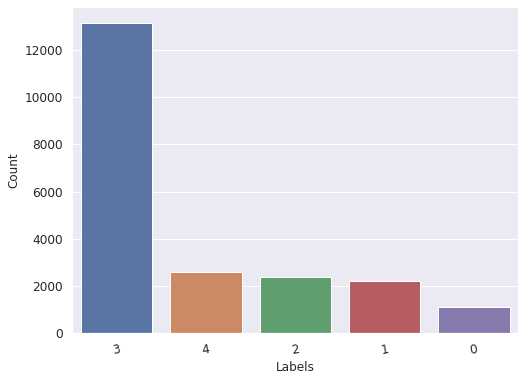

In [4]:
fig = plt.figure(figsize=(8, 6))

sns.set(font_scale=1.1)
label_count = sns.countplot(x='label', data=train_read, order = train_read['label'].value_counts().index)
label_count.set_xticklabels(label_count.get_xticklabels(), rotation=10)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.show()

Highly Class Imbalance Data : Class weight can be used later on. 
Sparse class or categroical class ? For simplicity I went along with sparse class, also going via categorical (one hot encoding the labels) path takes a lot of time (training the data).  

In [5]:
with open(dir_path + '/label_num_to_disease_map.json') as f:
    labelnames = json.loads(f.read())
    labelnames = {int(k): v for k,v in labelnames.items()}

print(labelnames)
print(labelnames[4])

{0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassava Brown Streak Disease (CBSD)', 2: 'Cassava Green Mottle (CGM)', 3: 'Cassava Mosaic Disease (CMD)', 4: 'Healthy'}
Healthy


In [6]:
### this was done to check sparse categorical cross entropy part 
### otherwise can be omitted 
train_read['label'] = train_read['label'].astype('string')
train_read.head(3)

image_id label
0  1000015157.jpg     0
1  1000201771.jpg     3
2   100042118.jpg     1

#### Visualize Different Classes of Disease 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


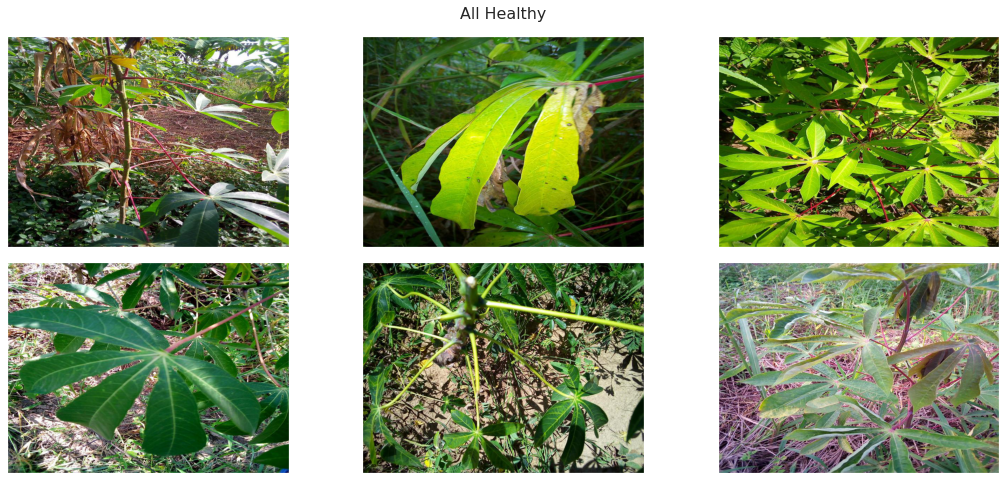

In [7]:
train_im_path = dir_path + '/train_images/'


fig = plt.figure(figsize=(15, 10))
npics= 6

count = 1
image_list = train_read[train_read['label'] == str(list(labelnames.keys())[list(labelnames.values()).index('Healthy')])]['image_id'].sample(frac=1)[:npics].to_list()  
for i, img in enumerate(image_list):
    
    sample = os.path.join(train_im_path, img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(npics/2 , 3, count, xticks=[],yticks=[])   
    plt.imshow(sample_img)
    count +=1
fig.suptitle('All Healthy')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


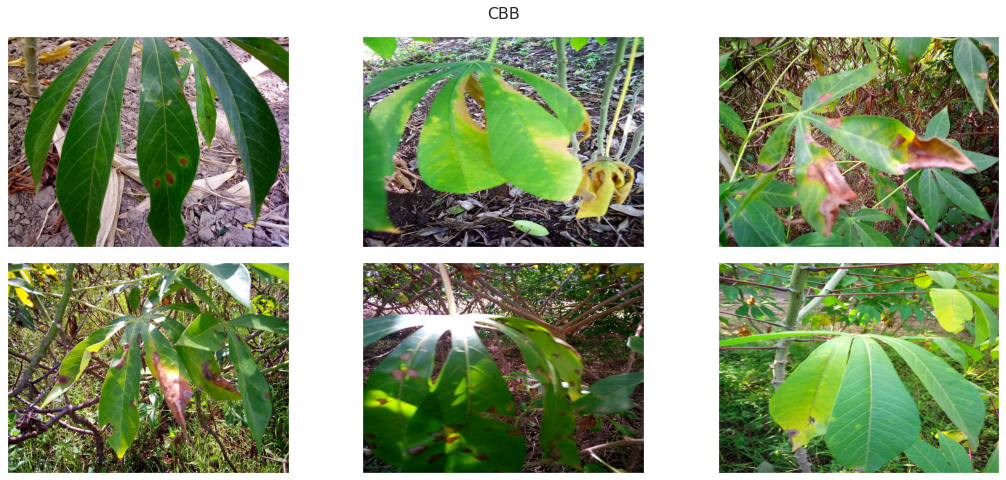

In [8]:
fig = plt.figure(figsize=(15, 10))
npics= 6

count = 1
image_list = train_read[train_read['label'] == str(list(labelnames.keys())[list(labelnames.values()).index('Cassava Bacterial Blight (CBB)')])]['image_id'].sample(frac=1)[:npics].to_list()  
for i, img in enumerate(image_list):
    
    sample = os.path.join(train_im_path, img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(npics/2 , 3, count, xticks=[],yticks=[])   
    plt.imshow(sample_img)
    count +=1
fig.suptitle('CBB')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


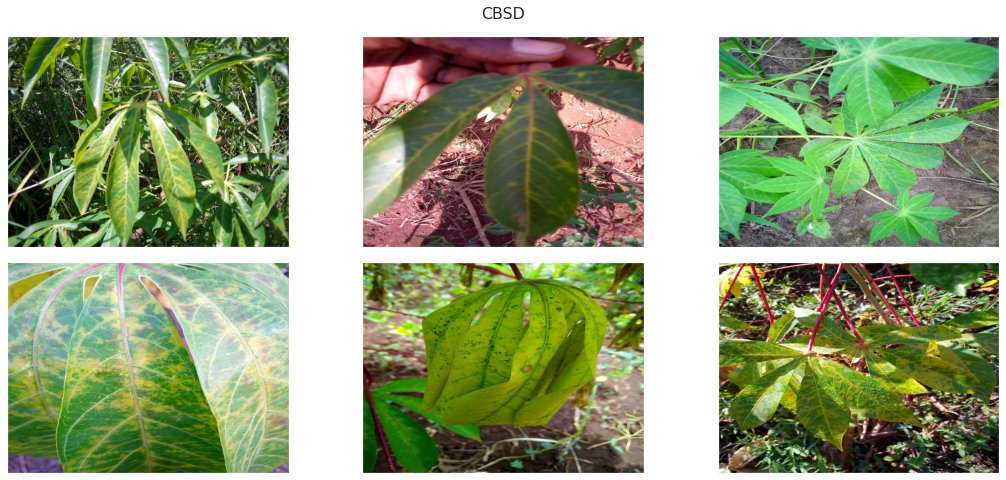

In [9]:
fig = plt.figure(figsize=(15, 10))
npics= 6

count = 1
image_list = train_read[train_read['label'] == str(list(labelnames.keys())[list(labelnames.values()).index('Cassava Brown Streak Disease (CBSD)')])]['image_id'].sample(frac=1)[:npics].to_list()  
for i, img in enumerate(image_list):
    
    sample = os.path.join(train_im_path, img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(npics/2 , 3, count, xticks=[],yticks=[])   
    plt.imshow(sample_img)
    count +=1
fig.suptitle('CBSD')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


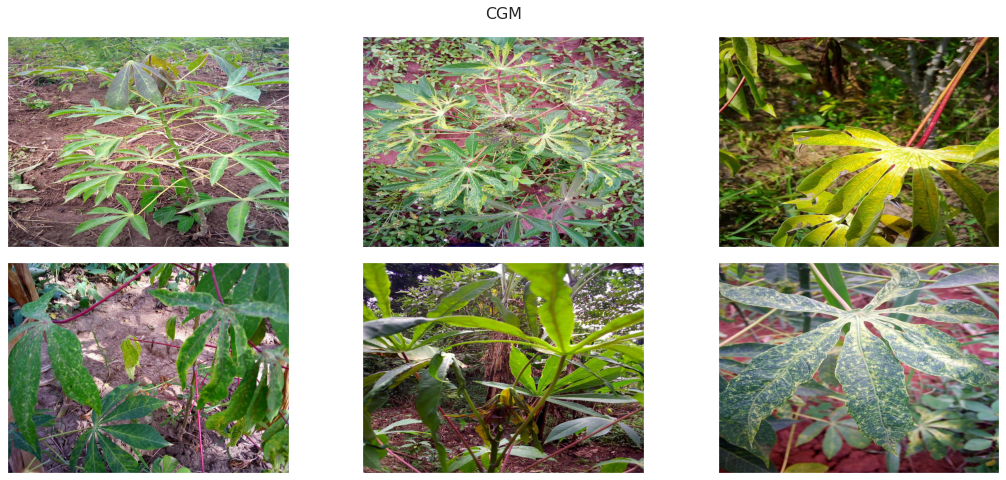

In [10]:
fig = plt.figure(figsize=(15, 10))
npics= 6

count = 1
image_list = train_read[train_read['label'] == str(list(labelnames.keys())[list(labelnames.values()).index('Cassava Green Mottle (CGM)')])]['image_id'].sample(frac=1)[:npics].to_list()  
for i, img in enumerate(image_list):
    
    sample = os.path.join(train_im_path, img) 
    sample_img = Image.open(sample)   
    ax = fig.add_subplot(npics/2 , 3, count, xticks=[],yticks=[])   
    plt.imshow(sample_img)
    count +=1
fig.suptitle('CGM')
plt.tight_layout()
plt.show()

#### How to Find Any Differences 

I spent some time reading about these diseases, because to be frank just from the images it is almost impossible to distinguish between different classes. 
After reading about the diseases and common symptoms I got even more confused because few of them show similar symptoms.   

For CBSD, I found [this document](http://www.fao.org/3/CA2940EN/ca2940en.pdf) really helpful. 

For CGM, I foind [this webpage](https://apps.lucidcentral.org/ppp_v9/text/web_full/entities/cassava_green_mottle_068.htm) helpful. The point is to show the similar symptoms between different diseases. 

In [this document](https://assets.publishing.service.gov.uk/media/57a08d8140f0b649740018d4/R7563RootsEng.pdf) the authors discussed about how CMD varies from region to region. 

* Later on after classification, I reached around 86% accuracy on validation data and to me it is surprisingly good. Because at least to my untrained eyes, they all looked very similar. 

Also since most of the images are of different leaves, it is better to resize the data (maybe something like center crop ?), which will reduce the training time. 

In [11]:
### check the image sizes if all are same or not 

im_name_lists = train_read['image_id'].tolist()
im_shape_x_lists = []
im_shape_y_lists = []
for i, img in enumerate(im_name_lists):
    sample = os.path.join(train_im_path, img) 
    sample_img = Image.open(sample)
    w, h = sample_img.size
#     im_shape_x_lists.append(sample_img.shape[0])
    im_shape_x_lists.append(w)
    im_shape_y_lists.append(h)
print ('check len: ', len(im_shape_x_lists), len(im_shape_y_lists))    

check len:  21397 21397


{800} {600}


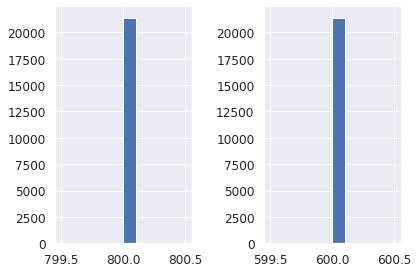

In [12]:
fig = plt.figure(figsize=(6, 4))

fig.add_subplot(121)
plt.hist(im_shape_x_lists)
fig.add_subplot(122)
plt.hist(im_shape_y_lists)
plt.tight_layout()

print (set(im_shape_x_lists), set(im_shape_y_lists)) # 600 x 800 images 

These images are too big and it would exhaust the time and resource to process with original size. 
So we will resize the image depending on the pretrained model. 

I will use InceptionResNetV2 so we will resize the images to 299x299 (wxh)

In [13]:
target_size = (300, 300)
input_shape = (300, 300, 3)
batch_size = 64

#### Create the Batch Generators  

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(validation_split=0.05)

train_generator = datagen.flow_from_dataframe(train_read,
                                              directory=train_im_path,
                                              x_col="image_id",
                                              y_col="label",
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode="sparse",
                                              subset="training",)

val_generator = datagen.flow_from_dataframe(train_read,
                                            directory=train_im_path,
                                            x_col="image_id",
                                            y_col="label",
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode="sparse", 
                                            subset="validation",)


Found 20328 validated image filenames belonging to 5 classes.
Found 1069 validated image filenames belonging to 5 classes.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


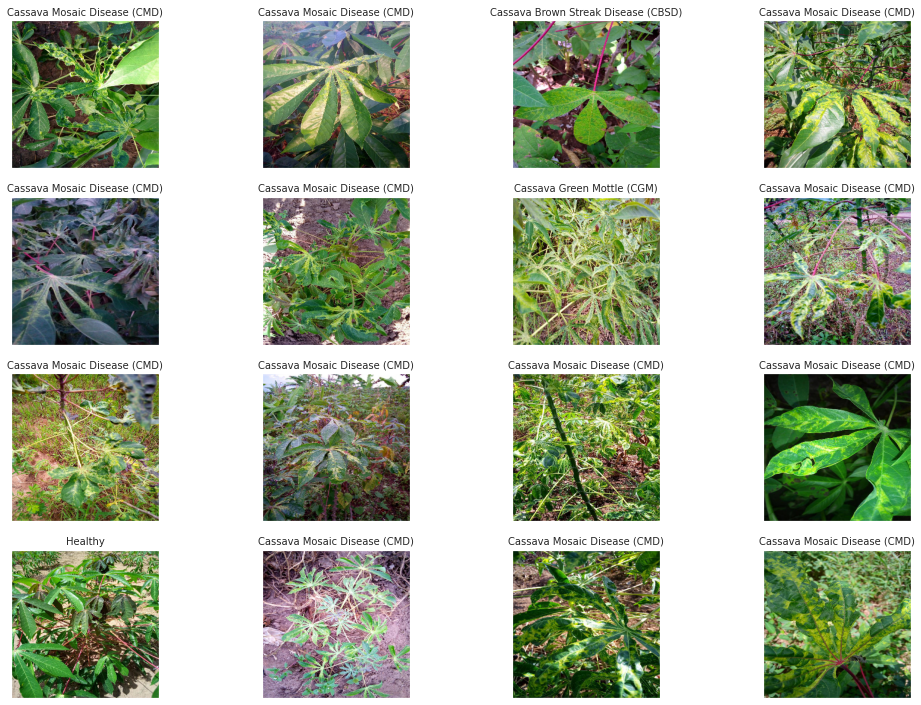

In [15]:
fig = plt.figure(figsize=(15, 10))
npics= 16
count = 1
for i in range(npics):
    x,y = val_generator.next()
    image = x[0].astype('uint8')
#     print (image.shape)
    label = y[0]  
    int_label = int(label)  
    ax = fig.add_subplot(npics/4 , 4, count, xticks=[],yticks=[])
    ax.set_title(labelnames[int_label], fontsize=10)  
    plt.imshow(image)
    count = count + 1  

plt.tight_layout()
plt.show()

### Build the Model Using Pre-Trained InceptionResNetV2

* We will also include augmentation as a model layer (Inspired from tf.data pipeline)
* Next target is to remove ImageDataGenerator completely.  

Added and tested Cosine Decay following [this notebook](https://www.kaggle.com/frlemarchand/efficientnet-aug-tf-keras-for-cassava-diseases) but the results are worse.  

In [16]:
## This cell was used to compile the baseline model
### Cosine Decay was tested

class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 2 == 0:
      print (
          'epoch num {}, train loss: {}, validation loss: {}'.format(epoch, logs['loss'], logs['val_loss']))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)


# epochs = 20
# decay_steps = int(round(len(train_read)/batch_size))*epochs

# cosine_decay = CosineDecay(initial_learning_rate=8e-4, decay_steps=decay_steps, alpha=0.3)


mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
                           save_best_only=True, save_weights_only=True, monitor='val_loss')




es = EarlyStopping(monitor="val_loss", patience=10,)


# targets are not one hot encoded but integers so we use sparse_categorical crossentropy
### later one targets were converted to one hot encoded labels 

# final_Efficient_model.compile(optimizer=adam, 
#                               loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False,
#                                                                            label_smoothing=0.001,), 
#                               metrics=['accuracy',])

In [17]:
inception_resnet_v2 = InceptionResNetV2(
    include_top=False,
    weights="../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=input_shape,)

def build_model():
    inputs = Input(input_shape)
    
    x = preprocess_input(inputs)
    x = Rescaling(1./255)(x)
    
    ###### data augmentation layers
    x = RandomFlip()(x)
    x = RandomRotation(factor=0.3)(x)
    
    ###### InceptionResNetV2 + Some Top Layers
    x = BatchNormalization()(x)
    x = inception_resnet_v2(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)

    x = Dense(256, activation=LeakyReLU())(x)
    x = Dropout(0.80)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(5, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    return model


In [18]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 300, 300, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 300, 300, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 300, 300, 3)       0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 300, 300, 3)       12    

##### Add Class Weight 


Treatment for Unbalanced Data 

* Try Multi-class Focal Loss later 

**Class_Weight** worsens the performace, so omitted from newer versions. 

In [19]:
labels_int = pd.to_numeric(train_read['label'], errors='coerce')
print (type(labels_int))
labels_int_arr = labels_int.to_numpy()
# np.unique(labels_int_arr)
# labels_int_arr.shape

from sklearn.utils import class_weight
mod_class_weights = class_weight.compute_class_weight('balanced', 
                                                      np.unique(labels_int_arr), labels_int_arr)

print (mod_class_weights)
print (dict(enumerate(mod_class_weights)))

<class 'pandas.core.series.Series'>
[3.93689052 1.9549566  1.79354568 0.3252318  1.66061312]
{0: 3.9368905243790246, 1: 1.954956601187757, 2: 1.7935456831517183, 3: 0.3252317981456148, 4: 1.6606131160263873}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 3 1 ... 1 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [20]:
start_time = time.time()
history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=100, 
                    callbacks=[mcp_save, es, reduce_lr])

end_time = time.time()

Epoch 1/100
318/318 [==============================] - 447s 1s/step - loss: 1.3709 - accuracy: 0.5439 - val_loss: 2.7378 - val_accuracy: 0.1113
Epoch 2/100
318/318 [==============================] - 416s 1s/step - loss: 0.6454 - accuracy: 0.7710 - val_loss: 1.2593 - val_accuracy: 0.5164
Epoch 3/100
318/318 [==============================] - 414s 1s/step - loss: 0.5488 - accuracy: 0.8086 - val_loss: 0.5091 - val_accuracy: 0.8354
Epoch 4/100
318/318 [==============================] - 415s 1s/step - loss: 0.5169 - accuracy: 0.8235 - val_loss: 0.7402 - val_accuracy: 0.7362
Epoch 5/100
318/318 [==============================] - 417s 1s/step - loss: 0.4772 - accuracy: 0.8423 - val_loss: 1.9709 - val_accuracy: 0.4022

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
318/318 [==============================] - 417s 1s/step - loss: 0.4239 - accuracy: 0.8574 - val_loss: 0.3980 - val_accuracy: 0.8597
Epoch 7/100
318/318 [==============================] -

In [21]:
print ('total time taken: in Minutes', (end_time-start_time)/60.)

total time taken: in Minutes 140.29638959169387


#### Training and Validation Curves

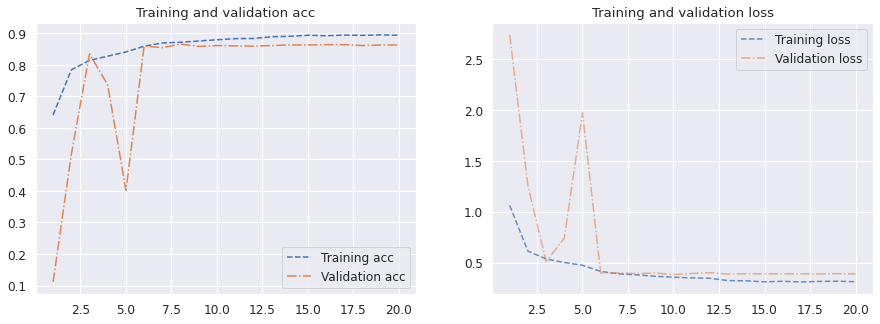

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)

plt.plot(epochs, acc, linestyle='--', label = "Training acc")
plt.plot(epochs, val_acc, linestyle='-.', label = "Validation acc")
plt.title("Training and validation acc")
plt.legend()

fig.add_subplot(122)
plt.plot(epochs, loss, linestyle='--', label = "Training loss", alpha=0.8)
plt.plot(epochs, val_loss, linestyle='-.', label = "Validation loss", alpha=0.6)
plt.title("Training and validation loss")
plt.legend()

plt.show()


In [23]:
model.evaluate(val_generator)

17/17 [==============================] - 13s 754ms/step - loss: 0.3884 - accuracy: 0.8634


[0.38839879631996155, 0.863423764705658]

In [24]:
### check if the model is still fine after loading the trained weights
model.load_weights("best_model_weights.h5")
model.evaluate(val_generator)

17/17 [==============================] - 13s 778ms/step - loss: 0.3821 - accuracy: 0.8616


[0.3821435868740082, 0.8615528345108032]

#### Preparing for Submission

In [25]:
submission_df = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
submission_df.head()


image_id  label
0  2216849948.jpg      4

In [26]:
preds = []
# preds_no_argmax = []


test_images = os.listdir('/kaggle/input/cassava-leaf-disease-classification/test_images/')
preds = []

for i in test_images:
    image = Image.open(f'/kaggle/input/cassava-leaf-disease-classification/test_images/{i}')
    image = image.resize(target_size)
    image = np.expand_dims(image, axis=0)
    preds.append(np.argmax(model.predict(image)))

In [27]:
df_sub = pd.DataFrame({'image_id': test_images, 'label': preds})
df_sub.head()

image_id  label
0  2216849948.jpg      2

In [28]:
df_sub.to_csv("submission.csv", index=None)

#### Plot the Confusion Matrix (Validation Data)

In [29]:
class_types = list(labelnames.values())
print (class_types)

['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


In [30]:
### try to plot the confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



def conf_matrix(test_lab, predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(8,8))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()

In [31]:
npics = 600 # try 500 examples 
valid_preds = []
all_valid_ims = []
all_valid_labels = []
for _ in range(npics):
    x,y = val_generator.next()
    image = x[0].astype('uint8')
    label = y[0]
    all_valid_labels.append(label)
    image = np.expand_dims(image, axis = 0)
    all_valid_ims.append(image)


In [32]:
all_valid_ims_arr = np.array(all_valid_ims)
all_valid_labels_arr = np.array(all_valid_labels)


all_valid_ims_arr = np.reshape(all_valid_ims_arr, (600, 300, 300, 3))

print ('check shapes now: ', all_valid_ims_arr.shape, all_valid_labels_arr.shape)


check shapes now:  (600, 300, 300, 3) (600,)


In [33]:
pred_class_InceptResV2 = model.predict(all_valid_ims_arr)
print ('check shape of preds: ', pred_class_InceptResV2.shape)

check shape of preds:  (600, 5)


Classification Report:

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.29      0.48      0.36        29
Cassava Brown Streak Disease (CBSD)       0.93      0.70      0.80        80
         Cassava Green Mottle (CGM)       0.88      0.79      0.83        56
       Cassava Mosaic Disease (CMD)       0.97      0.97      0.97       368
                            Healthy       0.69      0.73      0.71        67

                           accuracy                           0.87       600
                          macro avg       0.75      0.73      0.73       600
                       weighted avg       0.89      0.87      0.88       600



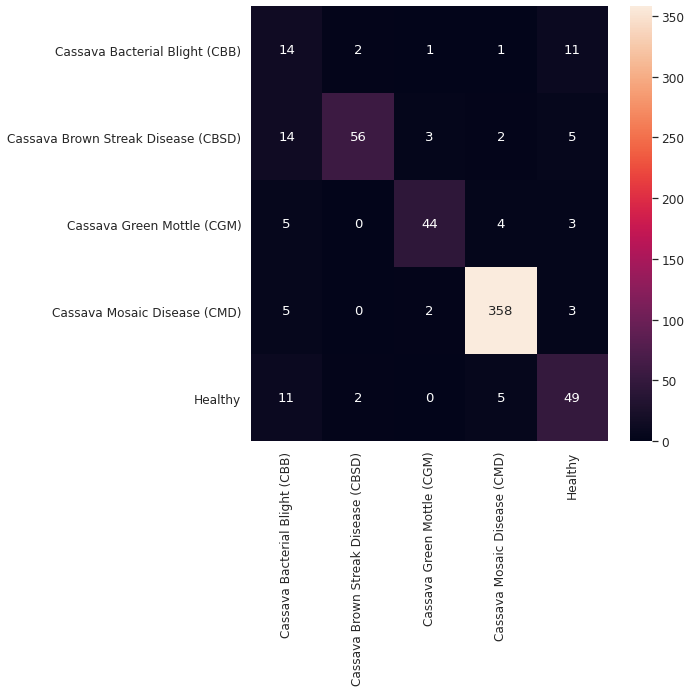

In [34]:
conf_matrix(np.int32(all_valid_labels_arr), pred_class_InceptResV2)